In [34]:
from mGST.utility_functions_comparisons import get_x_from_k, get_full_mgst_parameters_from_configuration
from mGST.algorithm import gd
from mGST.low_level_jit import cost_function_jax_jit
from iqm.benchmarks.compressive_gst.compressive_gst import GSTConfiguration

import jax.numpy as jnp
import jax

backend = "iqmfakeapollo"

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# GDS: with line search `minimize`

## 2GST

In [21]:
Q2_GST = GSTConfiguration(
    qubit_layouts=[[0, 1]],
    gate_set="2QXYCZ",
    num_circuits=800,
    shots=1000,
    rank=4,
)

K, X, E, rho, y, J, l, d, pdim, r, n_povm, bsize, meas_samples, n, nt, rK = get_full_mgst_parameters_from_configuration(
    Q2_GST, backend
)

2025-01-15 12:36:30,851 - iqm.benchmarks.logging_config - INFO - Now generating 800 random GST circuits...
2025-01-15 12:36:31,013 - iqm.benchmarks.logging_config - INFO - Will transpile all 800 circuits according to fixed physical layout
2025-01-15 12:36:31,013 - iqm.benchmarks.logging_config - INFO - Transpiling for backend IQMFakeApolloBackend with optimization level 0, sabre routing method all circuits
2025-01-15 12:36:32,647 - iqm.benchmarks.logging_config - INFO - Submitting batch with 800 circuits corresponding to qubits [0, 1]
2025-01-15 12:36:32,649 - iqm.benchmarks.logging_config - INFO - Now executing the corresponding circuit batch
2025-01-15 12:36:32,706 - iqm.benchmarks.logging_config - INFO - Retrieving all counts


In [22]:
# What is the cost function first of.
initial_cost = cost_function_jax_jit(K, d, r, E, rho, J, y)
fixed_gates = jnp.array([(f"G%i" % i in []) for i in range(d)])
J_processed = [row[row != -1] for row in J]
print(len(J_processed))
initial_cost

Array(0.00158172, dtype=float64)

In [23]:
# Let's time how long it takes to take the gradient descent in one step currently
gds_kwargs = {"use_jax":True}
%time K_gd = gd(K, E, rho, y, J_processed, d, r, rK, fixed_gates=fixed_gates, ls="COBYLA", **gds_kwargs)
# previous: CPU times: user 6.96 s, sys: 2.79 s, total: 9.74 s
# Wall time: 5.62 s

800
Using JAX power
CPU times: user 45 s, sys: 21.3 s, total: 1min 6s
Wall time: 13.2 s


In [24]:
%timeit gd(K, E, rho, y, J_processed, d, r, rK, fixed_gates=fixed_gates, ls="COBYLA", **gds_kwargs)
# previous: 2.69 s ± 30.5 ms

Using JAX power
Using JAX power
Using JAX power
Using JAX power
Using JAX power
Using JAX power
Using JAX power
Using JAX power
8.5 s ± 1.08 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%timeit gd(K, E, rho, y, J, d, r, rK, fixed_gates=fixed_gates, ls="COBYLA", **{"use_jax":False})

772 ms ± 19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
# Let's do a profilling of gd with JAX to better understand where the bottle necks are.
%prun -D profile_gd_jax_single_step_line_search.prof gd(K, E, rho, y, J, d, r, rK, fixed_gates=fixed_gates, ls="COBYLA", **gds_kwargs)

Using JAX power
 
*** Profile stats marshalled to file 'profile_gd_jax_single_step_line_search.prof'.


         20235261 function calls (20046342 primitive calls) in 12.721 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       25    3.561    0.142    9.754    0.390 low_level_jit.py:194(cost_function_jax_jit)
    80005    1.272    0.000    2.576    0.000 ufunc_api.py:172(__call__)
   208046    0.570    0.000    1.654    0.000 abstract_arrays.py:46(canonical_concrete_aval)
   236126    0.453    0.000    0.509    0.000 core.py:1594(canonicalize_shape)
    14408    0.432    0.000    0.539    0.000 pjit.py:1736(_pjit_call_impl)
20855/17655    0.343    0.000    1.028    0.000 core.py:928(process_primitive)
  2741192    0.324    0.000    0.677    0.000 {built-in method builtins.isinstance}
     7204    0.166    0.000    2.863    0.000 pjit.py:2154(_pjit_partial_eval)
   208046    0.149    0.000    0.149    0.000 core.py:1762(_get_abstract_sharding)
    80065    0.130    0.000    2.958    0.000 array_methods.py:568(deferring_binary

In [13]:
# now with numba
%prun -D profile_gd_numba_single_step_line_search.prof gd(K, E, rho, y, J, d, r, rK, fixed_gates=fixed_gates, ls="COBYLA", **{"use_jax":False})

 
*** Profile stats marshalled to file 'profile_gd_numba_single_step_line_search.prof'.


         16887 function calls in 0.779 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.392    0.392    0.392    0.392 low_level_jit.py:398(dK)
       27    0.332    0.012    0.332    0.012 low_level_jit.py:107(objf)
        1    0.011    0.011    0.011    0.011 array_methods.py:961(<lambda>)
      140    0.009    0.000    0.010    0.000 linalg.py:1193(eig)
        1    0.008    0.008    0.779    0.779 algorithm.py:251(gd)
       28    0.004    0.000    0.029    0.001 optimization.py:60(update_K_geodesic)
      140    0.004    0.000    0.008    0.000 linalg.py:789(qr)
      140    0.003    0.000    0.004    0.000 linalg.py:492(inv)
      168    0.002    0.000    0.002    0.000 {built-in method numpy.core._multiarray_umath.c_einsum}
        1    0.002    0.002    0.364    0.364 _cobyla_py.py:189(_minimize_cobyla)
      451    0.001    0.000    0.001    0.000 {built-in method numpy.zeros}
      463    0.001    0

## 3GST

In [25]:
Q3_GST = GSTConfiguration(
    qubit_layouts=[[0,1,3]],
    gate_set="3QXYCZ",
    num_circuits=1000,
    shots=1000,
    rank=4,
)

K, X, E, rho, y, J, l, d, pdim, r, n_povm, bsize, meas_samples, n, nt, rK = get_full_mgst_parameters_from_configuration(
    Q3_GST, backend
)

2025-01-15 12:39:28,962 - iqm.benchmarks.logging_config - INFO - Now generating 1000 random GST circuits...
2025-01-15 12:39:29,177 - iqm.benchmarks.logging_config - INFO - Will transpile all 1000 circuits according to fixed physical layout
2025-01-15 12:39:29,178 - iqm.benchmarks.logging_config - INFO - Transpiling for backend IQMFakeApolloBackend with optimization level 0, sabre routing method all circuits
2025-01-15 12:39:31,536 - iqm.benchmarks.logging_config - INFO - Submitting batch with 1000 circuits corresponding to qubits [0, 1, 3]
2025-01-15 12:39:31,538 - iqm.benchmarks.logging_config - INFO - Now executing the corresponding circuit batch
2025-01-15 12:39:31,592 - iqm.benchmarks.logging_config - INFO - Retrieving all counts


In [26]:
# What is the cost function first of.
initial_cost = cost_function_jax_jit(K, d, r, E, rho, J, y)
fixed_gates = jnp.array([(f"G%i" % i in []) for i in range(d)])
J_processed = [row[row != -1] for row in J]

initial_cost, d, len(J_processed)

(Array(0.0007799, dtype=float64), 8, 1000)

In [27]:
gds_kwargs = {"use_jax":True}
%time K_gd = gd(K, E, rho, y, J_processed, d, r, rK, fixed_gates=fixed_gates, ls="COBYLA", **gds_kwargs)

Using JAX power
CPU times: user 2min 3s, sys: 59.6 s, total: 3min 2s
Wall time: 54.2 s


In [30]:
%time K_gd_numba = gd(K, E, rho, y, J, d, r, rK, fixed_gates=fixed_gates, ls="COBYLA", **{"use_jax":False})

CPU times: user 11min 54s, sys: 10min 12s, total: 22min 7s
Wall time: 2min 22s


In [31]:
jnp.allclose(K_gd_numba, K_gd)

Array(True, dtype=bool)

In [32]:
# Let's do a profilling of gd with JAX to better understand where the bottle necks are.
%prun -D profile_gd_jax_single_step_line_search_3qubits.prof gd(K, E, rho, y, J_processed, d, r, rK, fixed_gates=fixed_gates, ls="COBYLA", **gds_kwargs)

Using JAX power
 
*** Profile stats marshalled to file 'profile_gd_jax_single_step_line_search_3qubits.prof'.


         35944055 function calls (35513997 primitive calls) in 56.039 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       39   36.991    0.948   50.659    1.299 low_level_jit.py:194(cost_function_jax_jit)
   312008    4.809    0.000    7.949    0.000 ufunc_api.py:172(__call__)
   345881    0.921    0.000    1.325    0.000 core.py:1681(__init__)
   278857    0.776    0.000    2.546    0.000 abstract_arrays.py:46(canonical_concrete_aval)
    33991    0.724    0.000    0.970    0.000 pjit.py:1736(_pjit_call_impl)
   351664    0.691    0.000    0.797    0.000 partial_eval.py:531(aval)
5065249/5065199    0.623    0.000    1.464    0.000 {built-in method builtins.isinstance}
    17004    0.354    0.000    4.084    0.000 pjit.py:2154(_pjit_partial_eval)
   312102    0.308    0.000    8.855    0.000 array_methods.py:568(deferring_binary_op)
   936033    0.297    0.000    0.677    0.000 {built-in method _abc._abc_instancecheck}
 

In [33]:
# Let's do a profilling of gd with JAX to better understand where the bottle necks are.
%prun -D profile_gd_numba_single_step_line_search_3qubits.prof gd(K, E, rho, y, J, d, r, rK, fixed_gates=fixed_gates, ls="COBYLA", **{"use_jax":False})

 
*** Profile stats marshalled to file 'profile_gd_numba_single_step_line_search_3qubits.prof'.


         51417 function calls in 222.020 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1  106.677  106.677  106.677  106.677 low_level_jit.py:398(dK)
       54  101.222    1.874  101.222    1.874 low_level_jit.py:107(objf)
      440   13.502    0.031   13.507    0.031 linalg.py:492(inv)
      440    0.232    0.001    0.241    0.001 linalg.py:1193(eig)
      495    0.081    0.000    0.081    0.000 {built-in method numpy.core._multiarray_umath.c_einsum}
       55    0.080    0.001   14.030    0.255 optimization.py:60(update_K_geodesic)
      440    0.078    0.000    0.132    0.000 linalg.py:789(qr)
      440    0.025    0.000   13.805    0.031 optimization.py:11(eigy_expm)
        1    0.017    0.017    0.017    0.017 array_methods.py:961(<lambda>)
     1320    0.014    0.000    0.017    0.000 linalg.py:159(_commonType)
      880    0.009    0.000    0.009    0.000 {built-in method numpy.arange}
      880    0.007  

In [35]:
jax.local_device_count()

1

## Results

<table>
  <tr>
    <th>Function</th>
    <th>Numba</th>
    <th>JAX + JIT</th>
  </tr>
  <tr>
    <td colspan="3", style="text-align: center;">2 GST</td>
  <tr>
    <td>gd</td> 
    <td> 772 ms ± 19 ms</td>
    <td> 8.05 s ± 239 ms</td>
  </tr>
  <tr>
    <td>derivative</td>
    <td> 0.3919 s / 1 call / 50.32%</td>
    <td> 6.93 s / 1 call / 54.29%</td>
  </tr>
  <tr>
    <td>Minimize</td>
    <td> 0.3646 s / 1 call / 46.81%</td>
    <td> 5.829 s / 1 call / 45.68%</td>
  </tr>
  <tr>
    <td>cost function</td>
    <td> 0.3315 s / 27 calls / 42.56%</td>
    <td> 9.754 s / 25 calls/ 76.44% </td>
  </tr>
  <tr>
    <td colspan="3", style="text-align: center;">3 GST</td>
  <tr>
    <td>gd</td> 
    <td> 3mins 42s (profile) / 2min 22s (%time)</td>
    <td> 56.1 s</td>
  </tr>
  <tr>
    <td>derivative</td>
    <td> 106.7 s / 1 call / 48.05%</td>
    <td> 11.67 s / 1 call / 20.80% </td>
  </tr>
  <tr>
    <td>Minimize</td>
    <td> 115 s / 1 call / 51.82%</td>
    <td> 44.41 s / 1 call / 79.14%</td>
  </tr>
  <tr>
    <td>cost function</td>
    <td> 101 s / 54 calls / 45.59%</td>
    <td> 50.66 s / 39 calls / 90.28 </td>
  </tr>
  <tr>
</table>

* All times reported are cumulative times (time inside the function and subfunctions called form them)
* For numba, cost function is only called within `minimize`, unlike for `jax`.

# GDS: without line search

## 2GST

In [38]:
Q2_GST = GSTConfiguration(
    qubit_layouts=[[0, 1]],
    gate_set="2QXYCZ",
    num_circuits=800,
    shots=1000,
    rank=4,
)

K, X, E, rho, y, J, l, d, pdim, r, n_povm, bsize, meas_samples, n, nt, rK = get_full_mgst_parameters_from_configuration(
    Q2_GST, backend
)

2025-01-15 16:31:08,246 - iqm.benchmarks.logging_config - INFO - Now generating 800 random GST circuits...
2025-01-15 16:31:08,413 - iqm.benchmarks.logging_config - INFO - Will transpile all 800 circuits according to fixed physical layout
2025-01-15 16:31:08,413 - iqm.benchmarks.logging_config - INFO - Transpiling for backend IQMFakeApolloBackend with optimization level 0, sabre routing method all circuits
2025-01-15 16:31:09,770 - iqm.benchmarks.logging_config - INFO - Submitting batch with 800 circuits corresponding to qubits [0, 1]
2025-01-15 16:31:09,774 - iqm.benchmarks.logging_config - INFO - Now executing the corresponding circuit batch
2025-01-15 16:31:09,800 - iqm.benchmarks.logging_config - INFO - Retrieving all counts


In [39]:
# What is the cost function first of.
initial_cost = cost_function_jax_jit(K, d, r, E, rho, J, y)
fixed_gates = jnp.array([(f"G%i" % i in []) for i in range(d)])
J_processed = [row[row != -1] for row in J]
print(len(J_processed))
initial_cost

800


Array(0.00172574, dtype=float64)

In [74]:
%timeit gd(K, E, rho, y, J, d, r, rK, fixed_gates=fixed_gates, ls="COBYLA", **{"use_jax":False, "optimize_step":True})

750 ms ± 29.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [76]:
%timeit gd(K, E, rho, y, J, d, r, rK, fixed_gates=fixed_gates, ls="COBYLA", **{"use_jax":False, "optimize_step":False, "step_size":1})

495 ms ± 54.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


This comparison shows that performing a single line search at this point does not have a huge effect:

* With line search: 750 ms ± 29.1 ms
* Without line search: 495 ms ± 54.2 ms

difference =  750 - 495 = 255 ms.

Each evaluation of the cost function takes: 8.83 ms ± 22 μs (see `gst_opt_testbed.ipynb`). Which means that approximately this difference comes from the evaluation of 255/8.83 $\approx$ 28 extra cost functions.

In [78]:
%timeit gd(K, E, rho, y, J_processed, d, r, rK, fixed_gates=fixed_gates, ls="COBYLA", **{"use_jax":True, "optimize_step":False, "step_size":1})

Using JAX power
Using JAX power
Using JAX power
Using JAX power
Using JAX power
Using JAX power
Using JAX power
Using JAX power
2.05 s ± 36.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


This agrees with the values we obtain for the calculation of the gradient and the profiling from above. This means now most of the time is spent in calculating a single gradient.

From `gst_gradient_time_comparison.ipynb`: one gradient takes 411 ms ± 18.6 ms (so 84 ms are spent in the rest). 

**NEXT:** Let's use numba (since it's faster) to see how is the gds step size changing

In [80]:
E.shape, Q2_GST.shots

((4, 16), 1000)

In [46]:
from mGST.utility_functions_comparisons import run_simple_gds_on_gates

In [50]:
K_opt_2gst_ls, cost_function_history_2gst_ls = run_simple_gds_on_gates(
    K0=K,
    E=E,
    rho=rho,
    y=y,
    J=J,
    d=d,
    r=r,
    rK=rK,
    fixed_gates=fixed_gates,
    max_iter=200,
    gds_kwargs={"optimize_step":True, "verbose":True}
)

iteration:  0
cost:  0.0017257376220373908
optimized step size:  [5.06718282]
iteration:  1
cost:  0.0013705048202252077
optimized step size:  [8.32759259]
iteration:  2
cost:  0.001239934690633561
optimized step size:  [5.54521017]
iteration:  3
cost:  0.001171930219644352
optimized step size:  [9.42031017]
iteration:  4
cost:  0.0011218711532049713
optimized step size:  [5.8021461]
iteration:  5
cost:  0.0010789467853432667
optimized step size:  [9.54731915]
iteration:  6
cost:  0.001037964384451987
optimized step size:  [5.74872345]
iteration:  7
cost:  0.0009970528430724597
optimized step size:  [9.2474586]
iteration:  8
cost:  0.0009563999122413383
optimized step size:  [5.66581564]
iteration:  9
cost:  0.0009151616863166688
optimized step size:  [9.02763204]
iteration:  10
cost:  0.0008740652658915867
optimized step size:  [5.64228985]
iteration:  11
cost:  0.0008327946996492932
optimized step size:  [8.94096212]
iteration:  12
cost:  0.0007920528292506747
optimized step size:  [

In [57]:
K_opt_2gst, cost_function_history_2gst = run_simple_gds_on_gates(
    K0=K,
    E=E,
    rho=rho,
    y=y,
    J=J,
    d=d,
    r=r,
    rK=rK,
    fixed_gates=fixed_gates,
    max_iter=400,
    gds_kwargs={"optimize_step":False, "step_size":5, "verbose":True}
)

iteration:  0
cost:  0.0017257376220373908
iteration:  1
cost:  0.0013705676892785163
iteration:  2
cost:  0.001261559369756881
iteration:  3
cost:  0.0012020304825949848
iteration:  4
cost:  0.0011604901113259772
iteration:  5
cost:  0.0011269674182553236
iteration:  6
cost:  0.0010972337009412755
iteration:  7
cost:  0.0010692454670466053
iteration:  8
cost:  0.0010419567135204985
iteration:  9
cost:  0.0010148226309349467
iteration:  10
cost:  0.0009875681030198037
iteration:  11
cost:  0.0009600727998732204
iteration:  12
cost:  0.0009323111163097087
iteration:  13
cost:  0.0009043189718990114
iteration:  14
cost:  0.0008761741615991532
iteration:  15
cost:  0.0008479836473623869
iteration:  16
cost:  0.0008198744467115486
iteration:  17
cost:  0.000791986399921482
iteration:  18
cost:  0.0007644659600092367
iteration:  19
cost:  0.0007374606158121037
iteration:  20
cost:  0.000711113820425877
iteration:  21
cost:  0.0006855604398421277
iteration:  22
cost:  0.0006609228065270043
i

We see a difference in time of (approx) 184.5 s - 165.3 s =  `19.2 s`

This is actually not a lot! We can approximate even more exactly, since the cost function crosses the optimized value using LS after `325` iterations (see below). This means we can instead calculate:

184.5 x 325/400 = 149.906 s, which is then even less!

In [86]:
K_opt_2gst_shorter, cost_function_history_2gst_shorter = run_simple_gds_on_gates(
    K0=K,
    E=E,
    rho=rho,
    y=y,
    J=J,
    d=d,
    r=r,
    rK=rK,
    fixed_gates=fixed_gates,
    max_iter=325,
    gds_kwargs={"optimize_step":False, "step_size":5, "verbose":True}
)

iteration:  0
cost:  0.0017257376220373908
iteration:  1
cost:  0.0013705676892785163
iteration:  2
cost:  0.001261559369756881
iteration:  3
cost:  0.0012020304825949848
iteration:  4
cost:  0.0011604901113259772
iteration:  5
cost:  0.0011269674182553236
iteration:  6
cost:  0.0010972337009412755
iteration:  7
cost:  0.0010692454670466053
iteration:  8
cost:  0.0010419567135204985
iteration:  9
cost:  0.0010148226309349467
iteration:  10
cost:  0.0009875681030198037
iteration:  11
cost:  0.0009600727998732204
iteration:  12
cost:  0.0009323111163097087
iteration:  13
cost:  0.0009043189718990114
iteration:  14
cost:  0.0008761741615991532
iteration:  15
cost:  0.0008479836473623869
iteration:  16
cost:  0.0008198744467115486
iteration:  17
cost:  0.000791986399921482
iteration:  18
cost:  0.0007644659600092367
iteration:  19
cost:  0.0007374606158121037
iteration:  20
cost:  0.000711113820425877
iteration:  21
cost:  0.0006855604398421277
iteration:  22
cost:  0.0006609228065270043
i

Now we confirm out assumptions, running only 325 times took: 150.6 s!

In [85]:
rho.shape, rK, J.shape

((16,), 4, (800, 14))

In [52]:
import matplotlib.pyplot as plt

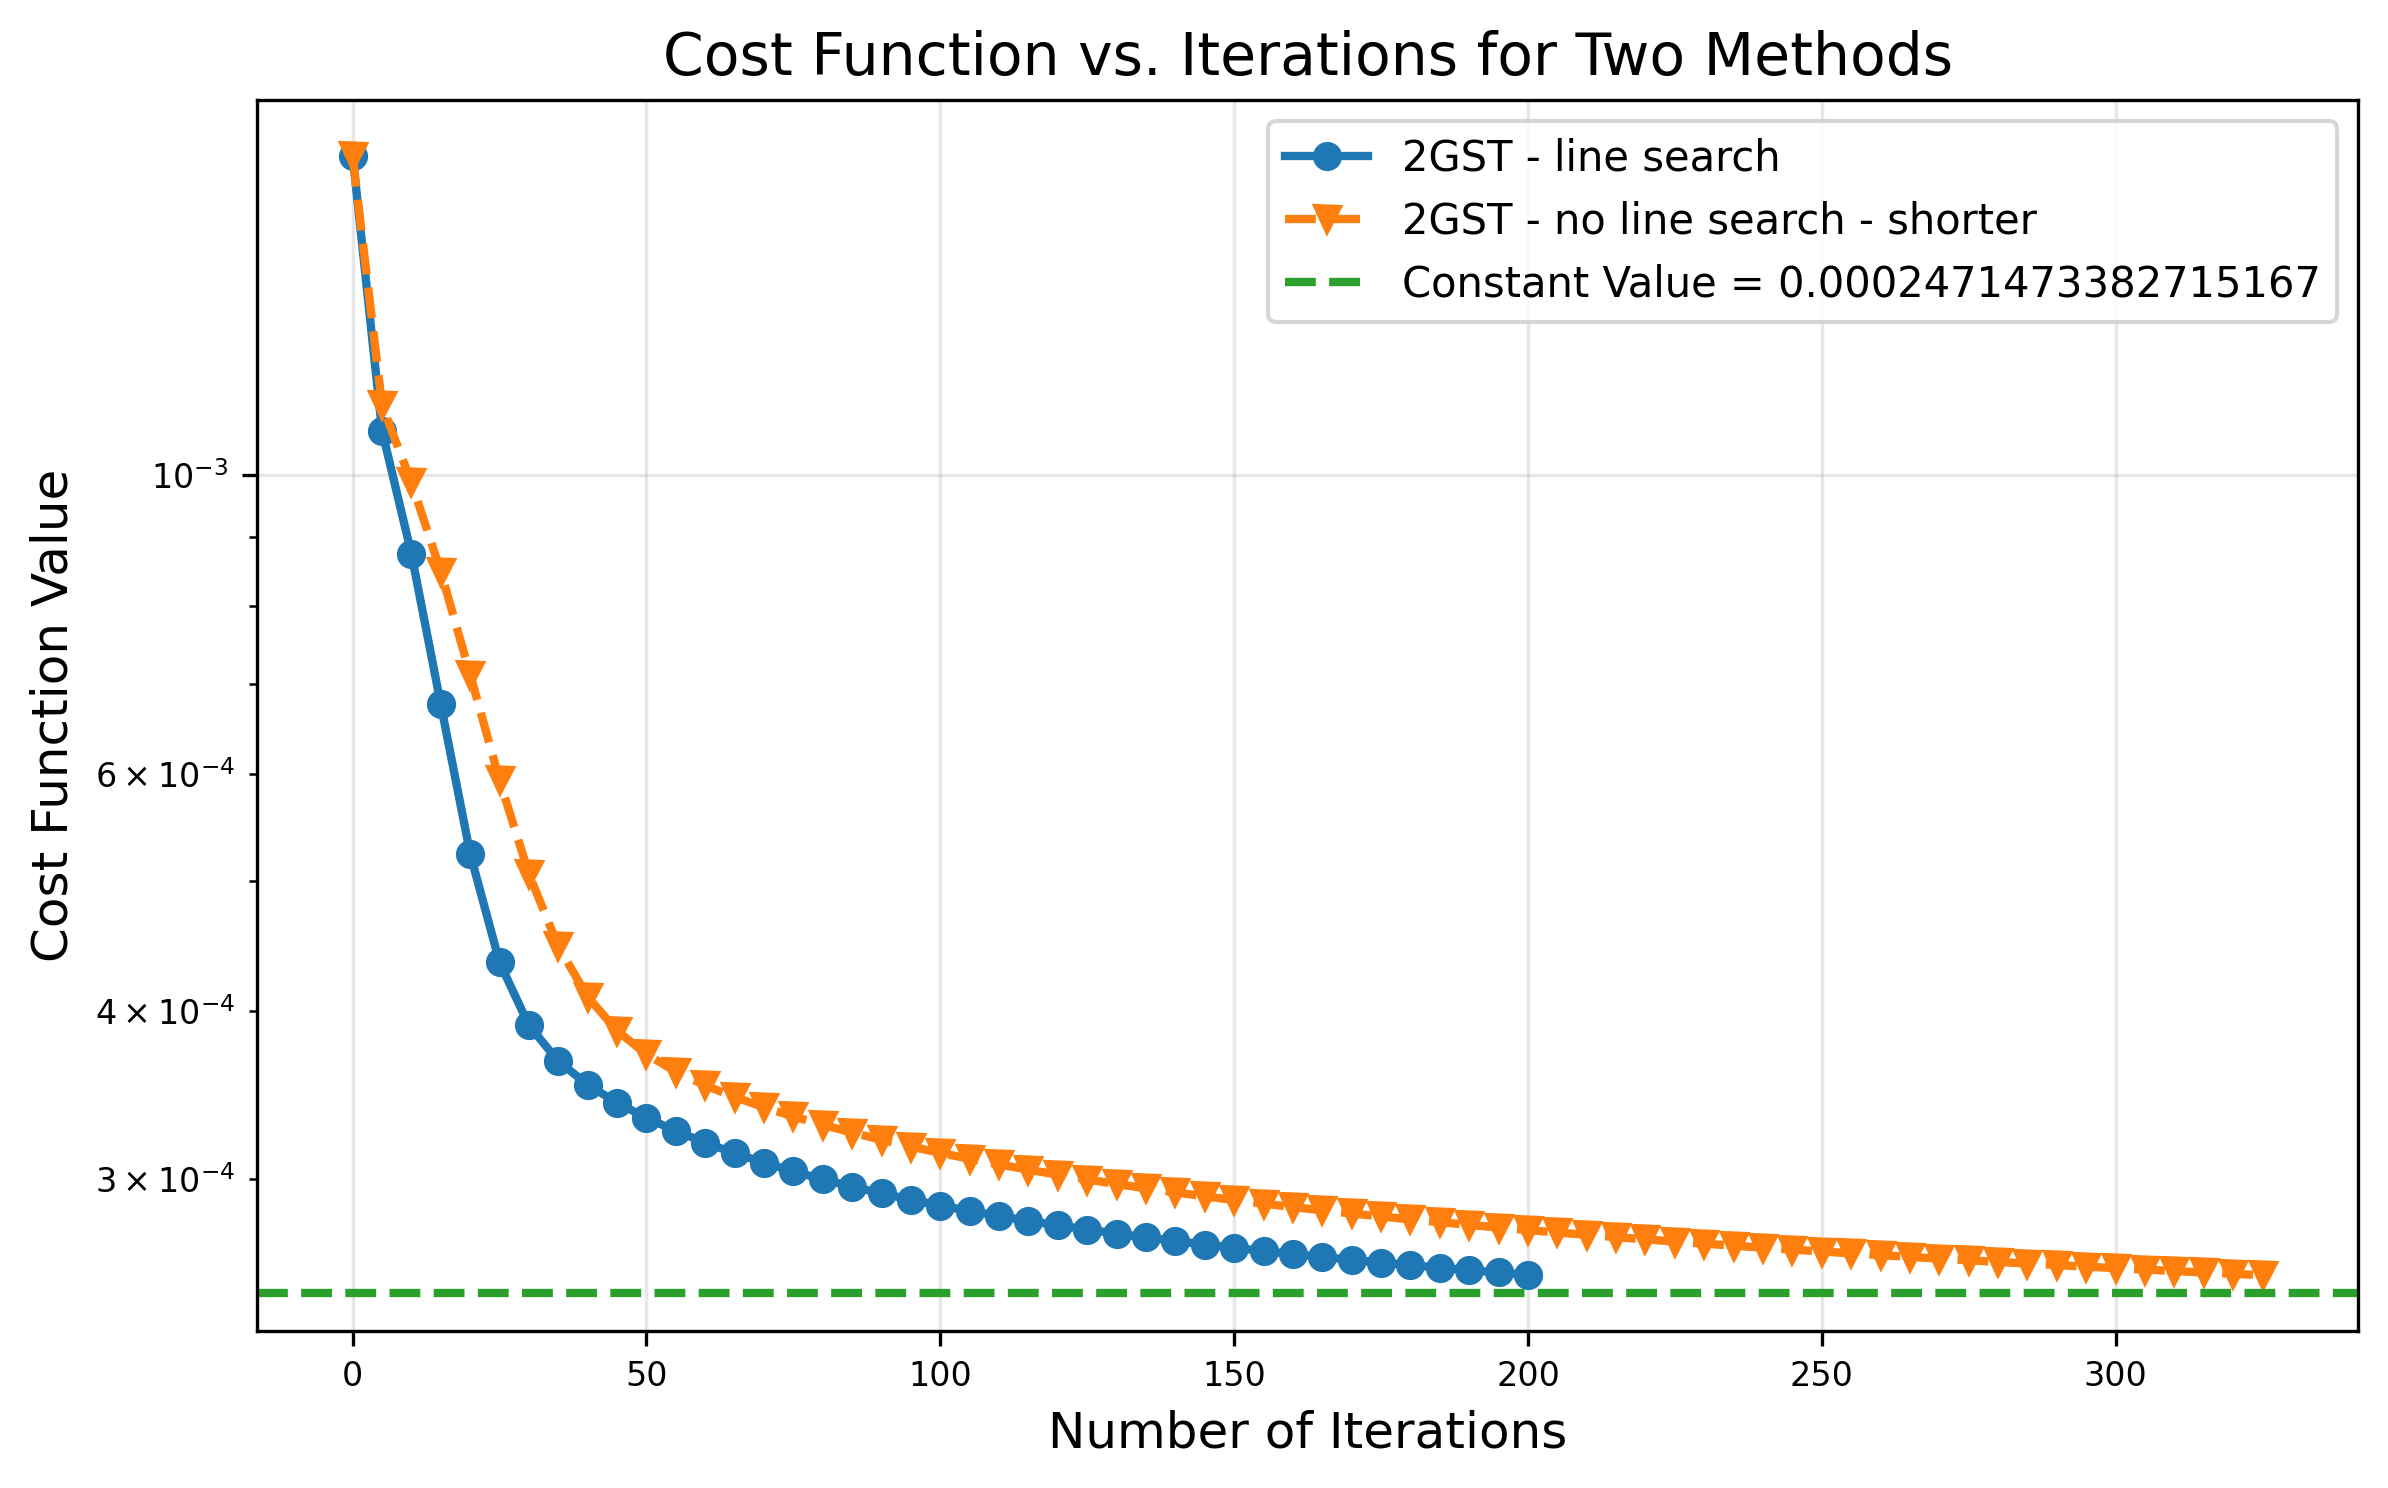

In [92]:
# Create the plot
plt.figure(figsize=(8, 5), dpi=300)

plot_step = 5
# Plot for method 1
plt.semilogy(range(len(cost_function_history_2gst_ls))[::plot_step], cost_function_history_2gst_ls[::plot_step], label="2GST - line search", color="#1f77b4", linestyle="-", marker="o", linewidth=2, markersize=6)
# Plot for method 2
# plt.semilogy(range(len(cost_function_history_2gst))[::plot_step], cost_function_history_2gst[::plot_step], label="2GST - no line search", color="#ff7f0e", linestyle="--", marker="s", linewidth=2, markersize=6)
plt.semilogy(range(len(cost_function_history_2gst_shorter))[::plot_step], cost_function_history_2gst_shorter[::plot_step], label="2GST - no line search - shorter ", color="#ff7f0e", linestyle="--", marker="v", linewidth=2, markersize=6)


constant_value = cost_function_history_2gst[-1]
plt.axhline(y=constant_value, color="#2ca02c", linestyle="--", linewidth=2, label=f"Constant Value = {constant_value}")

# Add labels, legend, and grid
plt.xlabel("Number of Iterations", fontsize=12)
plt.ylabel("Cost Function Value", fontsize=12)
plt.title("Cost Function vs. Iterations for Two Methods", fontsize=14)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

In [96]:
jnp.log10((cost_function_history_2gst_ls[-2] - cost_function_history_2gst_ls[-1])/cost_function_history_2gst_ls[-2])

Array(-3.1131701, dtype=float64)

In [84]:
# crossing point
best_value_ls = cost_function_history_2gst_ls[-1]
cross_idx = jnp.argmax(jnp.array(cost_function_history_2gst) <= best_value_ls)
cross_idx

Array(324, dtype=int64)

In [89]:
# crossing point
best_value_ls = cost_function_history_2gst_ls[-1]
jnp.argmax(jnp.array(cost_function_history_2gst_shorter) <= best_value_ls)

Array(324, dtype=int64)

We then have a good indicator that not performing the line search is actually more beneficial. 

The important point is to get a good GDS update step (in this case in the same order of the optimal (~9) was enough -we chose 5).

It is important to note we are not really comparing to a converged value here (see the exponential is not quite -4, but rather -3.1131701).

Also, we should take into account that we are not optimized the state and the POVM, only the gates. That can also affect how good our optimization can be.

# General notes:

2GST:

- `dK_jax_jit` is the one taking the most time 95% of the time
- `minimize` is a far second, 4.65%.
- Each of these functions is only called once, so JITing is also not an option (at least for single step).

> From these results, I don't expect to have significant improvements by avoiding the line search.

I have to take into account, however, that `obj` (numba) is still call several times (24) and that takes the 4.40% of the full time - average 13.08 ms per call. While `cost_function_jax_jit` is called once (for gradient) and it takes 54.59% of the total time.

**Question:** is this still the case for higher qubit count? From an old profiling, this doesn't seem to hold. It seems like for a 3GST, with a total running time of 168, `minimize` takes 63.65% of the time, and `dK` (not JAX) takes 36.18%. There, `obj` is called 68 times, with a 52.69% of the total time -average of 1.298 s per call. `dK` is only called once, again.

Now, when using `dK_jax` (an old implementation that was using JIT only for the contraction). There `minimize` still takes most of the time, with 75.47% of the computation, while `dK_jax` takes 24.28%. Once again, `obj` takes the most time since it is being called 45 times (within `minimize`), with an average per call of 1.603 s (as expected from previous tests of cost function).

Does dK scale? (JAX-JIT)
- 2GST: 6.80 s (3.89 s cost function)
- 3GST: 26.9 s (16.8 s cost function)

# 3GST

In [97]:
# Let's pause the full 3 GDS test until I have optimized/studied the cost function!